# PySIT example: horizontal reflectors

This notebook requires PySIT, which requires Python 2.

    pip install pysit


In [1]:
# Std import block
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pysit import *
from pysit.gallery import horizontal_reflector

/Users/matt/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics
EndFontMetrics


In [3]:
# Define domain.
pmlx = PML(0.1, 100)
pmlz = PML(0.1, 100)

x_config = (0.1, 1.0, pmlx, pmlx)
z_config = (0.1, 0.8, pmlz, pmlz)

d = RectangularDomain(x_config, z_config)

m = CartesianMesh(d, 90, 70)

# Generate true wave speed.
C, C0, m, d = horizontal_reflector(m)

# Set up shots.
zmin = d.z.lbound
zmax = d.z.rbound
zpos = zmin + (1./9.)*zmax

shots = equispaced_acquisition(m,
                               RickerWavelet(10.0),
                               sources=1,
                               source_depth=zpos,
                               source_kwargs={},
                               receivers='max',
                               receiver_depth=zpos,
                               receiver_kwargs={},
                               )

# Define and configure the wave solver.
trange = (0.0, 3.0)

solver = ConstantDensityAcousticWave(m,
                                     formulation='scalar',
                                     model_parameters={'C': C}, 
                                     spatial_accuracy_order=2,
                                     trange=trange,
                                     use_cpp_acceleration=True)

# Generate synthetic seismic data.
tt = time.time()
wavefields =  []
base_model = solver.ModelParameters(m,{'C': C})
generate_seismic_data(shots, solver, base_model, wavefields=wavefields)

print('Data generation: {0}s'.format(time.time()-tt))

objective = TemporalLeastSquares(solver)

# Define the inversion algorithm.
invalg = LBFGS(objective)
initial_value = solver.ModelParameters(m,{'C': C0})

# Execute inversion algorithm.
print('Running LBFGS...')
tt = time.time()

nsteps = 5

status_configuration = {'value_frequency'           : 1, 
                        'residual_frequency'        : 1, 
                        'residual_length_frequency' : 1, 
                        'objective_frequency'       : 1, 
                        'step_frequency'            : 1,
                        'step_length_frequency'     : 1,
                        'gradient_frequency'        : 1, 
                        'gradient_length_frequency' : 1, 
                        'run_time_frequency'        : 1, 
                        'alpha_frequency'           : 1,
                        }

# line_search = ('constant', 1e-16)
line_search = 'backtrack'

result = invalg(shots, initial_value, nsteps, 
                line_search=line_search, 
                status_configuration=status_configuration, verbose=True)

print '...run time:  {0}s'.format(time.time()-tt)

obj_vals = np.array([v for k,v in invalg.objective_history.items()])

Data generation: 1.5215959549s
Running LBFGS...
Iteration 0
  gradnorm 0.848689624313
  objective 0.000328374069781
  residual 0.0256270977592
  Starting:  45590.1551396 0.000328374069781


/Users/matt/anaconda/envs/python2/lib/python2.7/site-packages/pysit/solvers/model_parameter.py:74: RuntimeWarning: invalid value encountered in sqrt
  def unlinearize(cls, data): return np.sqrt(1./data)


  Pass 1: a:11.1304089696; 0.000469260081457 ?<= 0.000319450882057
  Pass 2: a:8.90432717571; 0.000314273881233 ?<= 0.000322663229637
  alpha 8.90432717571
  run time 6.1018640995s
Iteration 1
  gradnorm 3.49450387322
  objective 0.000314273881233
  residual 0.0250708548411
  Starting:  1.0 0.000314273881233
  Pass 1: a:1.0; 0.000363990059633 ?<= 0.000313744989961
  Pass 2: a:0.8; 0.000258319037264 ?<= 0.000313935390819
  alpha 0.8
  run time 6.78157901764s
Iteration 2
  gradnorm 4.25348861941
  objective 0.000258319037264
  residual 0.0227296738764
  Starting:  1.0 0.000258319037264
  Pass 1: a:1.0; 0.000101135879016 ?<= 0.000258037432615
  alpha 1.0
  run time 4.70485806465s
Iteration 3
  gradnorm 0.908402663024
  objective 0.000101135879016
  residual 0.0142222276044
  Starting:  1.0 0.000101135879016
  Pass 1: a:1.0; 8.65997639162e-05 ?<= 0.000101116078742
  alpha 1.0
  run time 3.91781115532s
Iteration 4
  gradnorm 0.562217366783
  objective 8.65997639162e-05
  residual 0.01316052

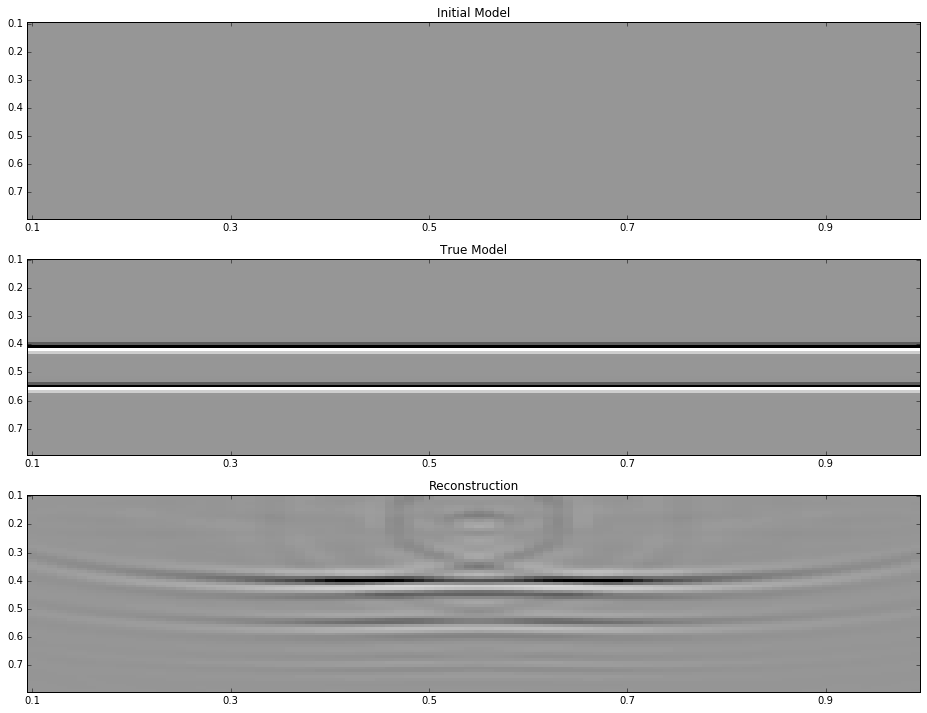

In [4]:
# plt.figure()
# plt.semilogy(obj_vals)

clim = C.min(),C.max()

# Do something to visualize the results
plt.figure(figsize=(16, 12))    
plt.subplot(3,1,1)
vis.plot(C0, m, clim=clim, cmap='Greys')
plt.title('Initial Model')

plt.subplot(3,1,2)
vis.plot(C, m, clim=clim, cmap='Greys')
plt.title('True Model')

plt.subplot(3,1,3)
vis.plot(result.C, m, clim=clim, cmap='Greys')
plt.title('Reconstruction')

plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>